In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [40]:
data_folder = os.path.join("..", "..", "data", "tarragona")

clean_data_folder = os.path.join(data_folder, "clean_data")

In [41]:
full_df = pd.read_excel(os.path.join(clean_data_folder, "full_dataset.xlsx"))

In [42]:
full_df

,DateTime,Nitrate (mg/L),Absorbance 254nm (un.Abs/m),pH,Ammonium (mg/L),Dissolved Oxygen (mg/L),Redox Potential (mV),Turbidity (NTU),Water Temperature (°C),Conductivity (µS/cm),Daily Cumulated Rainfall (L/m²),Air Temperature (°C),Flow River (m³/s)
0,2012-09-01,5.49,15.525,8.40,0.06,5.68,231.82,4.00,25.04,1254.15,0.0,17.81,94.97
1,2012-09-02,5.39,15.100,8.43,0.15,5.98,234.80,3.97,24.75,1244.10,0.0,19.43,95.48
2,2012-09-03,5.19,10.740,8.50,0.07,6.17,226.42,5.05,25.12,1208.12,0.0,21.67,95.18
3,2012-09-04,5.08,10.580,8.52,0.01,6.00,220.18,5.01,25.63,1192.20,0.0,22.89,95.71
4,2012-09-05,5.01,10.410,8.49,0.01,5.70,222.34,4.63,26.31,1196.83,0.0,23.16,96.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2023-09-26,7.56,3.970,8.30,0.03,5.46,227.69,3.96,25.95,1628.49,0.0,20.50,83.50
4043,2023-09-27,7.28,3.810,8.29,0.02,5.33,227.02,4.16,26.37,1610.67,0.0,21.76,81.17
4044,2023-09-28,7.34,3.760,8.27,0.02,5.23,228.25,3.80,26.60,1602.33,0.0,22.17,81.42
4045,2023-09-29,7.64,4.180,8.25,0.03,5.17,230.54,3.89,26.73,1613.81,0.0,22.03,80.71


In [43]:
full_df.columns.to_list()

['DateTime',
 'Nitrate (mg/L)',
 'Absorbance 254nm (un.Abs/m)',
 'pH',
 'Ammonium (mg/L)',
 'Dissolved Oxygen (mg/L)',
 'Redox Potential (mV)',
 'Turbidity (NTU)',
 'Water Temperature (°C)',
 'Conductivity (µS/cm)',
 'Daily Cumulated Rainfall (L/m²)',
 'Air Temperature (°C)',
 'Flow River (m³/s)']

# Get Abs values and define outliers

In [44]:
abs_df = full_df[["DateTime", "Absorbance 254nm (un.Abs/m)"]].copy()

In [45]:
abs_df["is_outlier"] = False

for year in abs_df["DateTime"].dt.year.unique():
    quartile_1, quartile_3 = abs_df[abs_df["DateTime"].dt.year == year][
        "Absorbance 254nm (un.Abs/m)"
    ].quantile([0.25, 0.75])

    iqr = quartile_3 - quartile_1

    lower_bound = max(quartile_1 - 1.5 * iqr, 0)
    upper_bound = quartile_3 + 1.5 * iqr

    abs_df.loc[abs_df["DateTime"].dt.year == year, "is_outlier"] = abs_df[abs_df["DateTime"].dt.year == year]["Absorbance 254nm (un.Abs/m)"] > upper_bound

In [46]:
abs_df['is_outlier'] = abs_df['is_outlier'].astype(int)

# Different settings of Logit models

In [47]:
abs_df['Year'] = abs_df['DateTime'].dt.year
abs_df['Month'] = abs_df['DateTime'].dt.month

In [48]:
abs_df.columns.to_list()

['DateTime', 'Absorbance 254nm (un.Abs/m)', 'is_outlier', 'Year', 'Month']

In [49]:
# Add a timestamp column
abs_df["Timestamp"] = abs_df["DateTime"].apply(lambda x: x.timestamp())

In [50]:
scaler = MinMaxScaler()
scaled_absorbance = scaler.fit_transform(abs_df["Absorbance 254nm (un.Abs/m)"].values.reshape(-1, 1))
scaled_peaks = scaler.fit_transform(abs_df["is_outlier"].values.reshape(-1, 1))

## Just the DateTime

In [51]:
logit_model = sm.GLM.from_formula("is_outlier ~ Timestamp", abs_df, family=sm.families.Binomial())

In [52]:
results = logit_model.fit()

In [53]:
print(results.wald_test_terms(scalar=True))

                chi2    P>chi2  df constraint
Intercept  19.894937  0.000008              1
Timestamp   3.710824  0.054061              1


In [54]:
print(results.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            1283.1603  
Link Function:      Logit            BIC:            -32317.5222
Dependent Variable: is_outlier       Log-Likelihood: -639.58    
Date:               2024-04-18 21:41 LL-Null:        -641.45    
No. Observations:   4047             Deviance:       1279.2     
Df Model:           1                Pearson chi2:   4.04e+03   
Df Residuals:       4045             Scale:          1.0000     
Method:             IRLS                                        
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Intercept    -5.7032    1.2786  -4.4604  0.0000  -8.2093  -3.1971
Timestamp     0.0000    0.0000   1.9263  0.0541  -0.0000   0.0000



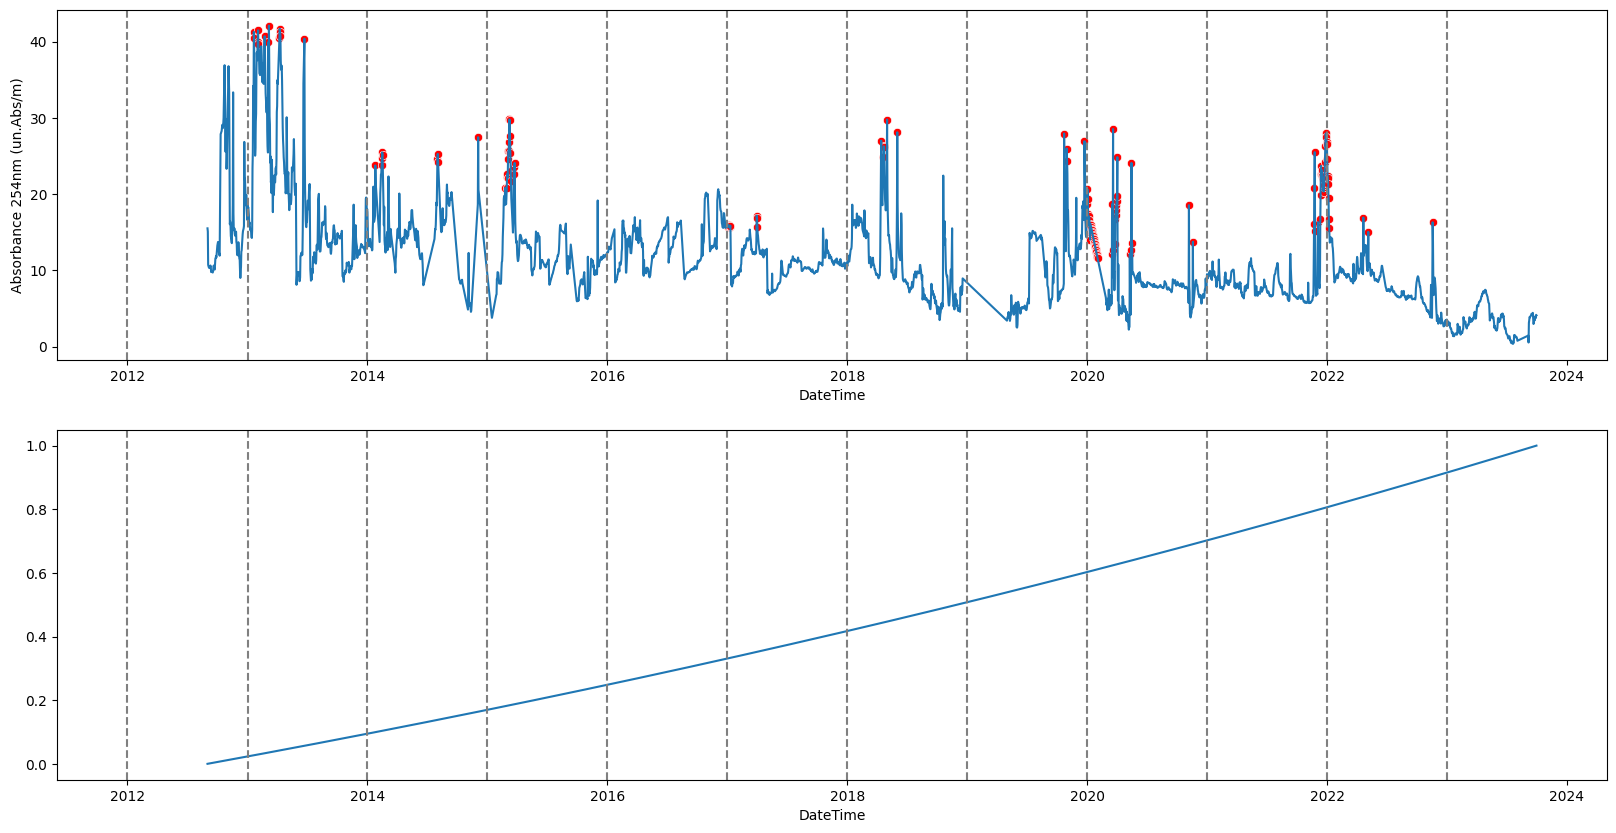

In [55]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm (un.Abs/m)', data=abs_df, ax=axs[0])
sns.scatterplot(x=abs_df['DateTime'], y=abs_df[abs_df['is_outlier'] == 1]['Absorbance 254nm (un.Abs/m)'], ax=axs[0], color='red')
sns.lineplot(x=abs_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in abs_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

## With the Year

In [56]:
logit_model = sm.GLM.from_formula("is_outlier ~ Timestamp + Year", abs_df, family=sm.families.Binomial())

In [57]:
results = logit_model.fit()

In [58]:
print(results.summary2())

                Results: Generalized linear model
Model:                GLM              AIC:            1224.9842  
Link Function:        Logit            BIC:            -32375.6982
Dependent Variable:   is_outlier       Log-Likelihood: -610.49    
Date:                 2024-04-18 21:41 LL-Null:        -641.45    
No. Observations:     4047             Deviance:       1221.0     
Df Model:             1                Pearson chi2:   4.56e+03   
Df Residuals:         4045             Scale:          1.0000     
Method:               IRLS                                        
------------------------------------------------------------------
            Coef.    Std.Err.    z    P>|z|    [0.025     0.975]  
------------------------------------------------------------------
Intercept -4627.7970 643.3028 -7.1938 0.0000 -5888.6473 -3366.9466
Timestamp    -0.0000   0.0000 -7.0189 0.0000    -0.0000    -0.0000
Year          2.3467   0.3266  7.1855 0.0000     1.7066     2.9868



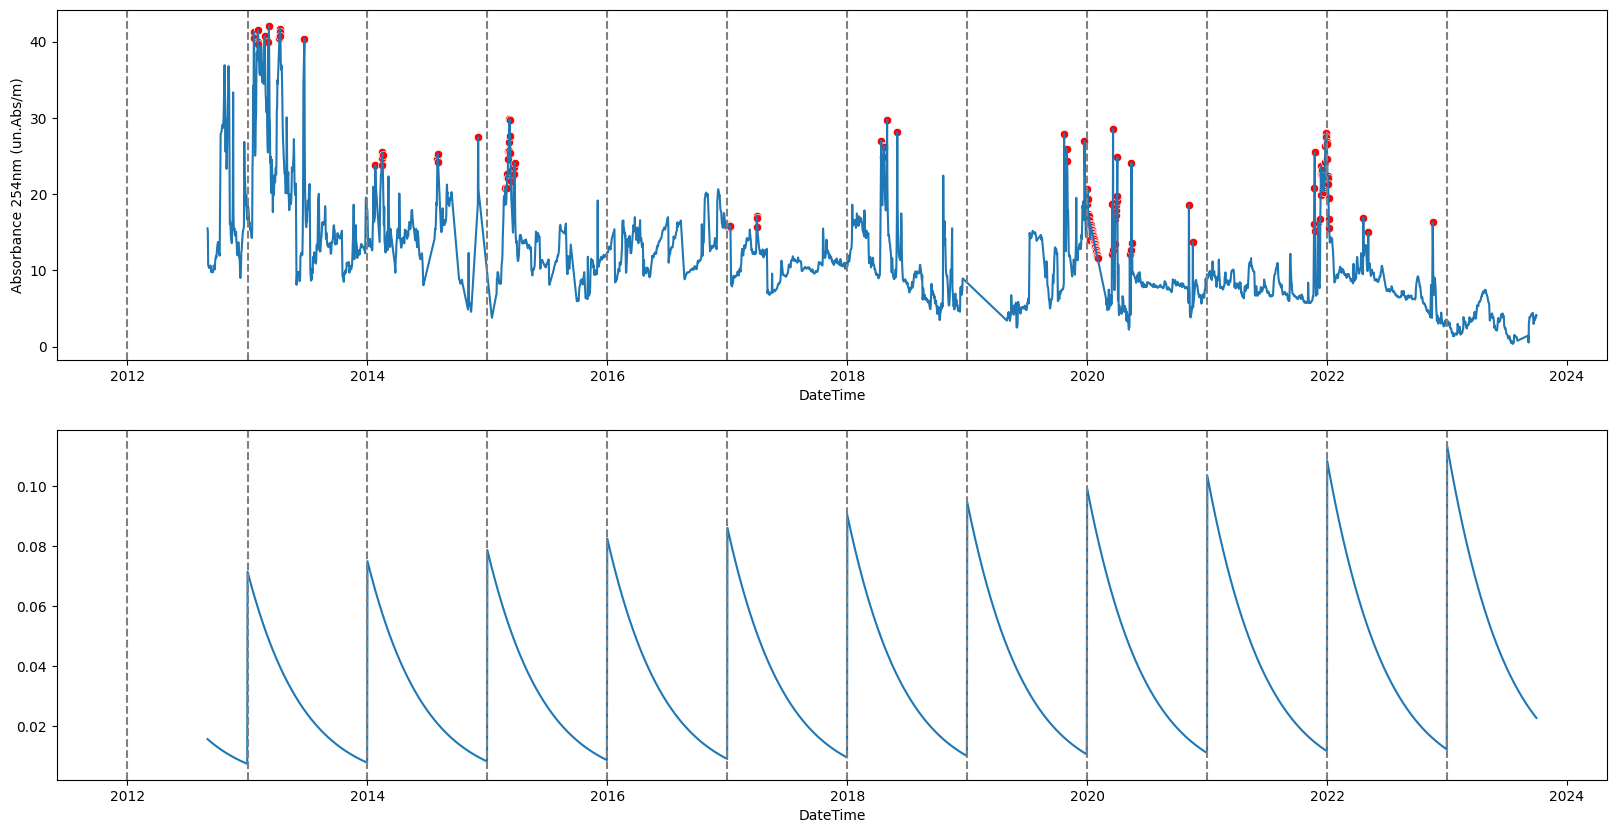

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm (un.Abs/m)', data=abs_df, ax=axs[0])
sns.scatterplot(x=abs_df['DateTime'], y=abs_df[abs_df['is_outlier'] == 1]['Absorbance 254nm (un.Abs/m)'], ax=axs[0], color='red')
sns.lineplot(x=abs_df['DateTime'], y=results.fittedvalues.values, ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in abs_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Interaction Term 

In [60]:
logit_model = sm.GLM.from_formula("is_outlier ~ Timestamp + Year + Timestamp * Year", abs_df, family=sm.families.Binomial())

In [61]:
results = logit_model.fit(maxiter=200)

In [62]:
print(results.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            1258.5236  
Link Function:      Logit            BIC:            -32335.8531
Dependent Variable: is_outlier       Log-Likelihood: -626.26    
Date:               2024-04-18 21:41 LL-Null:        -641.45    
No. Observations:   4047             Deviance:       1252.5     
Df Model:           2                Pearson chi2:   3.96e+03   
Df Residuals:       4044             Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept         0.0000   0.0000  4.6016 0.0000  0.0000  0.0000
Timestamp        -0.0000   0.0000 -5.0916 0.0000 -0.0000 -0.0000
Year              0.0278   0.0060  4.6016 0.0000  0.0159  0.0396
Timestamp:Year    0.0000   0.0000  5.0967

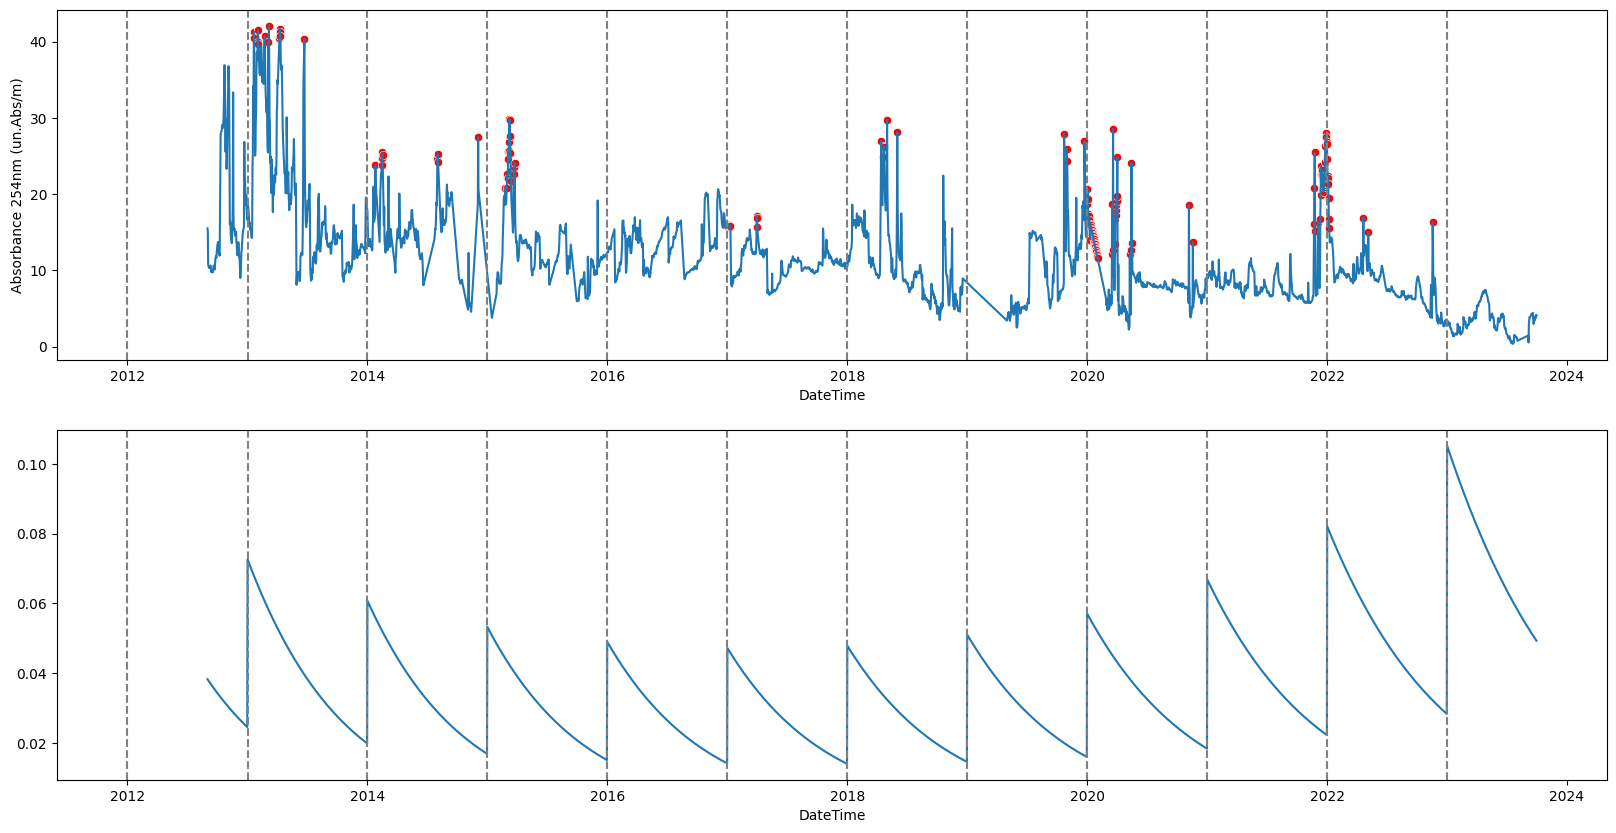

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm (un.Abs/m)', data=abs_df, ax=axs[0])
sns.scatterplot(x=abs_df['DateTime'], y=abs_df[abs_df['is_outlier'] == 1]['Absorbance 254nm (un.Abs/m)'], ax=axs[0], color='red')
sns.lineplot(x=abs_df['DateTime'], y=results.fittedvalues.values, ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in abs_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Per Year

In [345]:
logit_model = sm.GLM.from_formula("is_outlier ~ Timestamp + C(Year)", abs_df, family=sm.families.Binomial())

In [346]:
results = logit_model.fit(maxiter=1000)

In [347]:
print(results.summary2())

                    Results: Generalized linear model
Model:                 GLM                 AIC:               1165.3873  
Link Function:         Logit               BIC:               -32365.9322
Dependent Variable:    is_outlier          Log-Likelihood:    -569.69    
Date:                  2024-03-11 15:27    LL-Null:           -670.49    
No. Observations:      4047                Deviance:          1139.4     
Df Model:              12                  Pearson chi2:      4.33e+03   
Df Residuals:          4034                Scale:             1.0000     
Method:                IRLS                                              
-------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept       100.0810    13.9919  7.1528 0.0000     72.6573   127.5046
C(Year)[T.2013]   2.5096     0.7749  3.2386 0.0012      0.

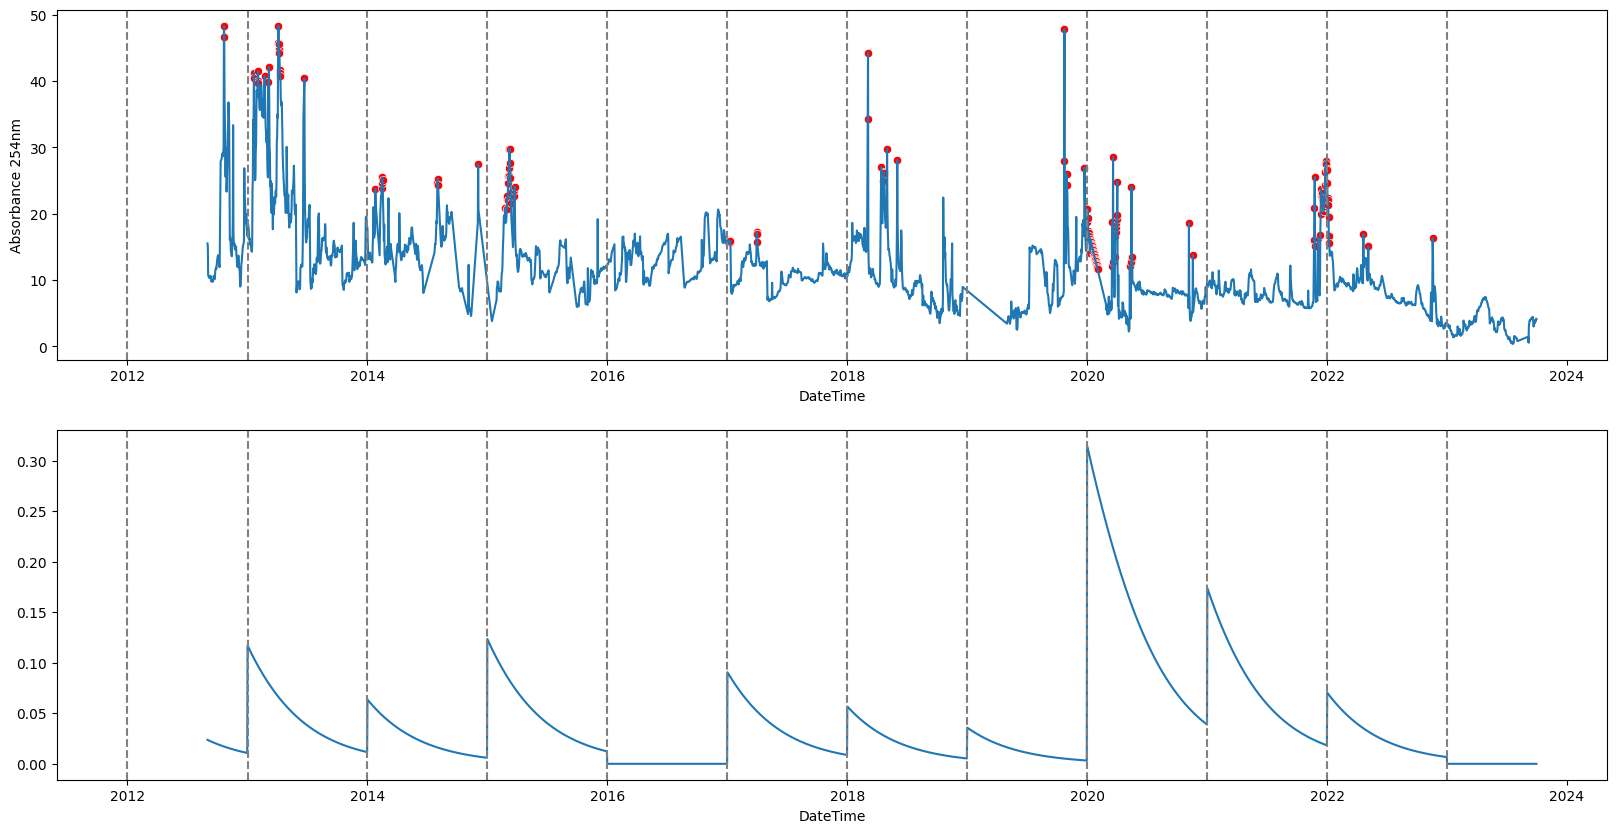

In [348]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=abs_df, ax=axs[0])
sns.scatterplot(x=abs_df['DateTime'], y=abs_df[abs_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=abs_df['DateTime'], y=results.fittedvalues.values, ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in abs_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Try with all variables

In [349]:
full_df['is_outlier'] = abs_df['is_outlier']
full_df['Timestamp'] = abs_df['Timestamp']
full_df['Year'] = abs_df['Year']
full_df['Month'] = abs_df['Month']

In [350]:
full_df.columns.to_list()

['DateTime',
 'Nitrate',
 'Absorbance 254nm',
 'pH',
 'Ammonium',
 'Dissolved Oxygen',
 'Redox Potential',
 'Turbidity',
 'Water Temperature',
 'Conductivity',
 'Daily Cumulated Rainfall',
 'Air Temperature',
 'Flow River',
 'is_outlier',
 'Timestamp',
 'Year',
 'Month']

In [351]:
formula = 'is_outlier ~ Timestamp + C(Year) + Q("Water Temperature") + Q("Daily Cumulated Rainfall") + Q("Air Temperature") + pH + Conductivity + Q("Flow River") + Nitrate + Ammonium + Q("Dissolved Oxygen") + Turbidity + Q("Redox Potential")'

In [352]:
logit_model = sm.GLM.from_formula(formula=formula, data=full_df, family=sm.families.Binomial())

In [353]:
results = logit_model.fit(maxiter=10000)

In [354]:
print(results.summary2())

                           Results: Generalized linear model
Model:                       GLM                     AIC:                   633.5673   
Link Function:               Logit                   BIC:                   -32828.3891
Dependent Variable:          is_outlier              Log-Likelihood:        -292.78    
Date:                        2024-03-11 15:27        LL-Null:               -670.49    
No. Observations:            4047                    Deviance:              585.57     
Df Model:                    23                      Pearson chi2:          1.14e+04   
Df Residuals:                4023                    Scale:                 1.0000     
Method:                      IRLS                                                      
---------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-----------------------------------------------------------

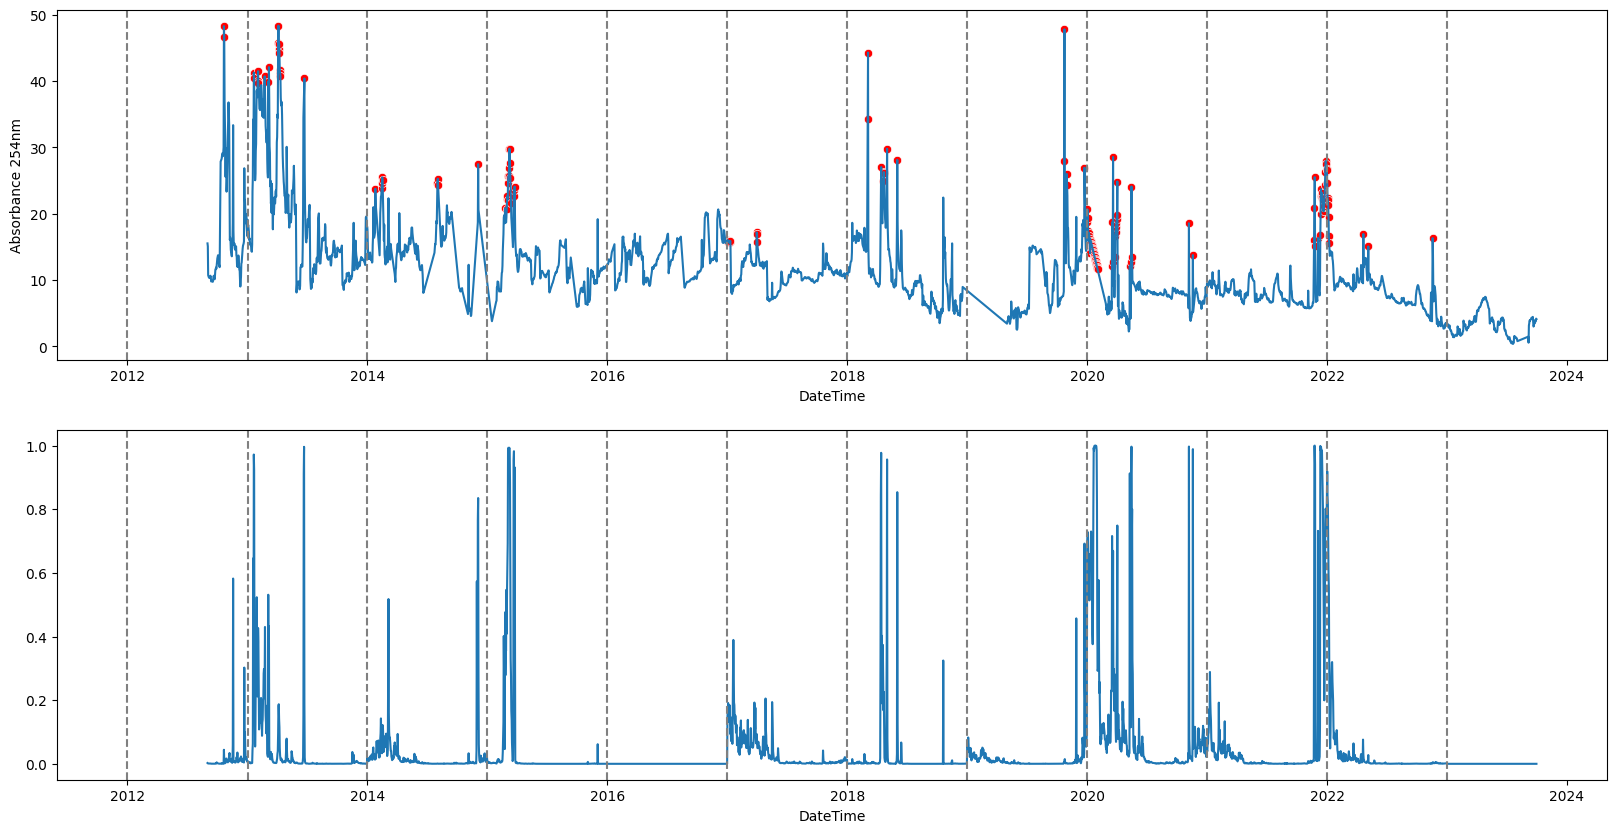

In [355]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=abs_df, ax=axs[0])
sns.scatterplot(x=abs_df['DateTime'], y=abs_df[abs_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=abs_df['DateTime'], y=results.fittedvalues.values, ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in abs_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Remove 2016 and 2023

In [356]:
removed_full_df = full_df

In [357]:
formula = 'is_outlier ~ Timestamp + C(Year) + Q("Water Temperature") + Q("Daily Cumulated Rainfall") + Q("Air Temperature") + pH + Conductivity + Q("Flow River") + Nitrate + Ammonium + Q("Dissolved Oxygen") + Turbidity + Q("Redox Potential")'

In [358]:
logit_model = sm.GLM.from_formula(formula=formula, data=removed_full_df, family=sm.families.Binomial())

In [359]:
results = logit_model.fit(maxiter=10000)

In [360]:
print(results.summary2())

                           Results: Generalized linear model
Model:                       GLM                     AIC:                   633.5673   
Link Function:               Logit                   BIC:                   -32828.3891
Dependent Variable:          is_outlier              Log-Likelihood:        -292.78    
Date:                        2024-03-11 15:27        LL-Null:               -670.49    
No. Observations:            4047                    Deviance:              585.57     
Df Model:                    23                      Pearson chi2:          1.14e+04   
Df Residuals:                4023                    Scale:                 1.0000     
Method:                      IRLS                                                      
---------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-----------------------------------------------------------

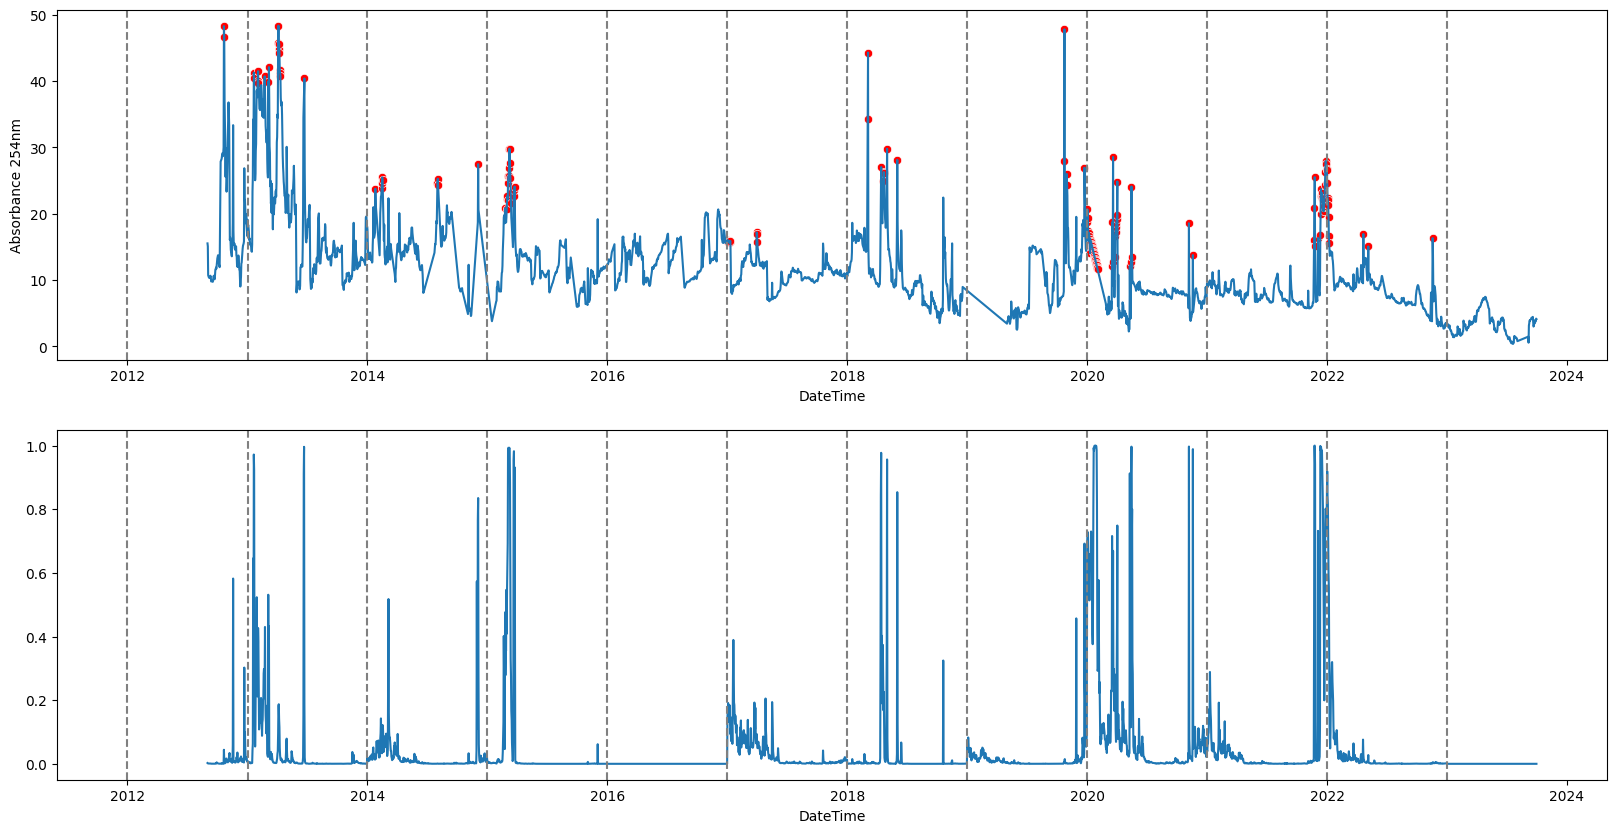

In [361]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=removed_full_df, ax=axs[0])
sns.scatterplot(x=removed_full_df['DateTime'], y=removed_full_df[removed_full_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Remove pH, Nitrate and Ammonium

In [362]:
formula = 'is_outlier ~ Timestamp + C(Year) + Q("Water Temperature") + Q("Daily Cumulated Rainfall") + Q("Air Temperature") + Conductivity + Q("Flow River") + Q("Dissolved Oxygen") + Turbidity + Q("Redox Potential")'

In [363]:
logit_model = sm.GLM.from_formula(formula=formula, data=removed_full_df, family=sm.families.Binomial())

In [364]:
results = logit_model.fit(maxiter=10000)

In [365]:
print(results.summary2())

                           Results: Generalized linear model
Model:                       GLM                     AIC:                   628.0822   
Link Function:               Logit                   BIC:                   -32852.7914
Dependent Variable:          is_outlier              Log-Likelihood:        -293.04    
Date:                        2024-03-11 15:27        LL-Null:               -670.49    
No. Observations:            4047                    Deviance:              586.08     
Df Model:                    20                      Pearson chi2:          1.15e+04   
Df Residuals:                4026                    Scale:                 1.0000     
Method:                      IRLS                                                      
---------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-----------------------------------------------------------

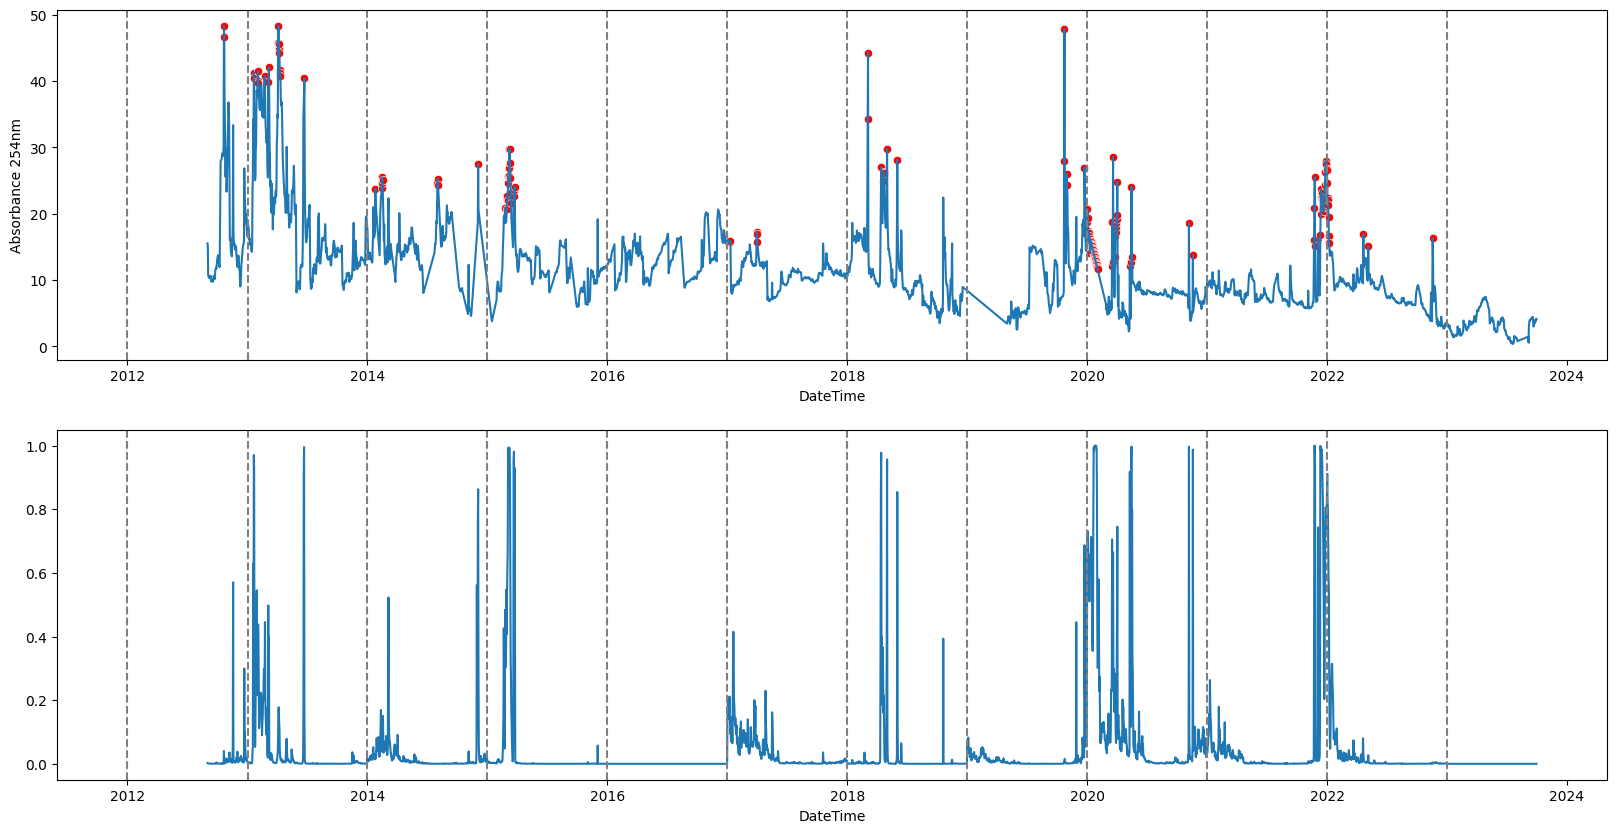

In [366]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=removed_full_df, ax=axs[0])
sns.scatterplot(x=removed_full_df['DateTime'], y=removed_full_df[removed_full_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Remove Flow River

In [367]:
formula = 'is_outlier ~ Timestamp + C(Year) + Q("Water Temperature") + Q("Daily Cumulated Rainfall") + Q("Air Temperature") + Conductivity + Q("Dissolved Oxygen") + Turbidity + Q("Redox Potential")'

In [368]:
logit_model = sm.GLM.from_formula(formula=formula, data=removed_full_df, family=sm.families.Binomial())

In [369]:
results = logit_model.fit(maxiter=10000)

In [370]:
print(results.summary2())

                           Results: Generalized linear model
Model:                       GLM                     AIC:                   626.1242   
Link Function:               Logit                   BIC:                   -32861.0551
Dependent Variable:          is_outlier              Log-Likelihood:        -293.06    
Date:                        2024-03-11 15:27        LL-Null:               -670.49    
No. Observations:            4047                    Deviance:              586.12     
Df Model:                    19                      Pearson chi2:          1.15e+04   
Df Residuals:                4027                    Scale:                 1.0000     
Method:                      IRLS                                                      
---------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-----------------------------------------------------------

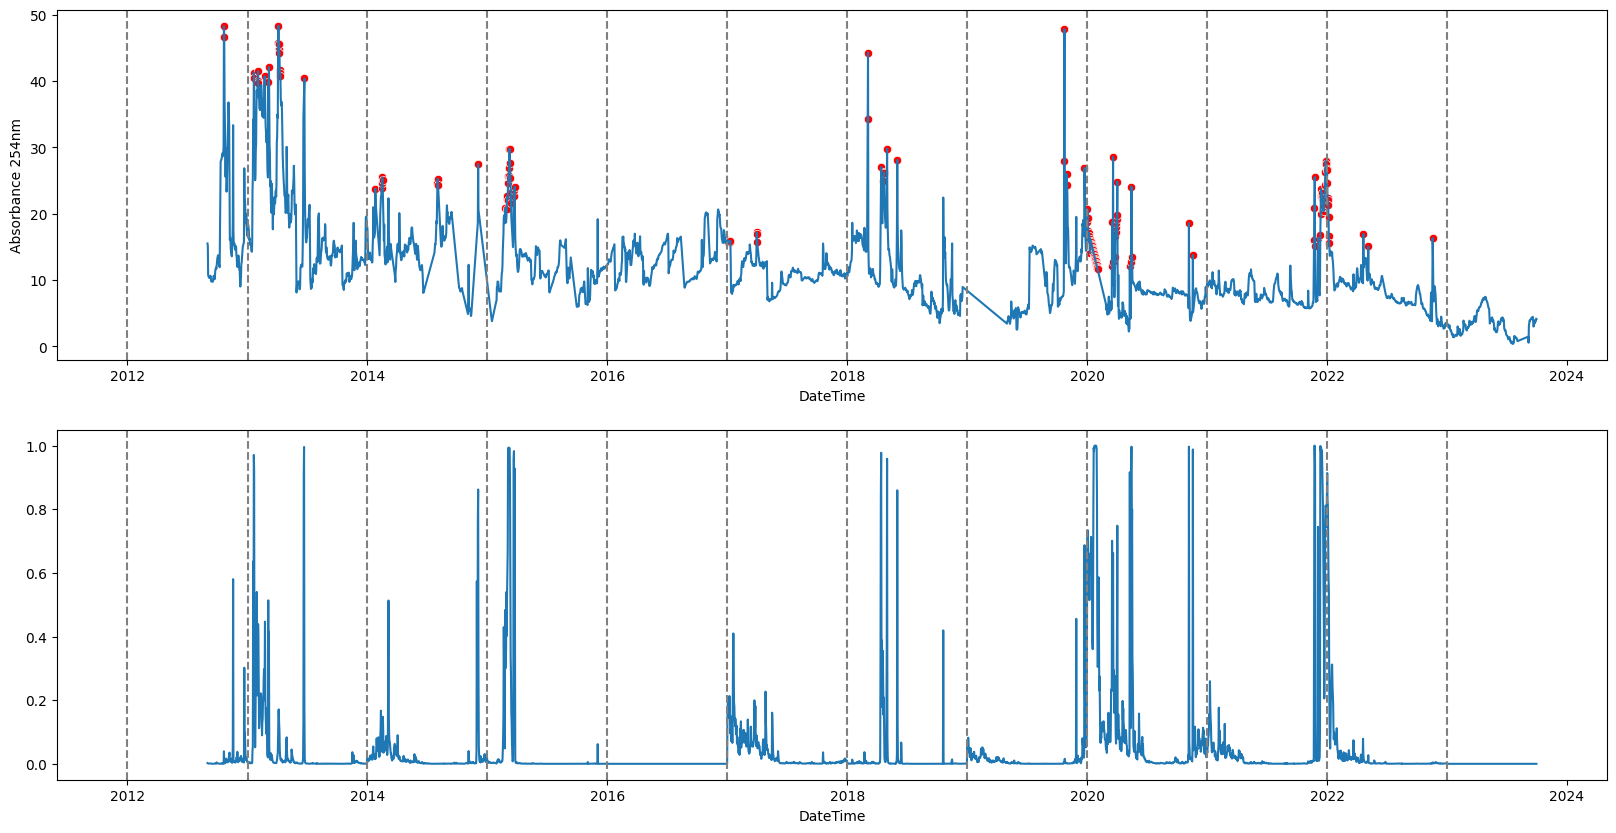

In [371]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=removed_full_df, ax=axs[0])
sns.scatterplot(x=removed_full_df['DateTime'], y=removed_full_df[removed_full_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Remove Water Temperature

In [372]:
formula = 'is_outlier ~ Timestamp + C(Year) + Q("Daily Cumulated Rainfall") + Q("Air Temperature") + Conductivity + Q("Dissolved Oxygen") + Turbidity + Q("Redox Potential")'

In [373]:
logit_model = sm.GLM.from_formula(formula=formula, data=removed_full_df, family=sm.families.Binomial())

In [374]:
results = logit_model.fit(maxiter=10000)

In [375]:
print(results.summary2())

                           Results: Generalized linear model
Model:                       GLM                     AIC:                   625.2474   
Link Function:               Logit                   BIC:                   -32868.2377
Dependent Variable:          is_outlier              Log-Likelihood:        -293.62    
Date:                        2024-03-11 15:27        LL-Null:               -670.49    
No. Observations:            4047                    Deviance:              587.25     
Df Model:                    18                      Pearson chi2:          1.01e+04   
Df Residuals:                4028                    Scale:                 1.0000     
Method:                      IRLS                                                      
---------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-----------------------------------------------------------

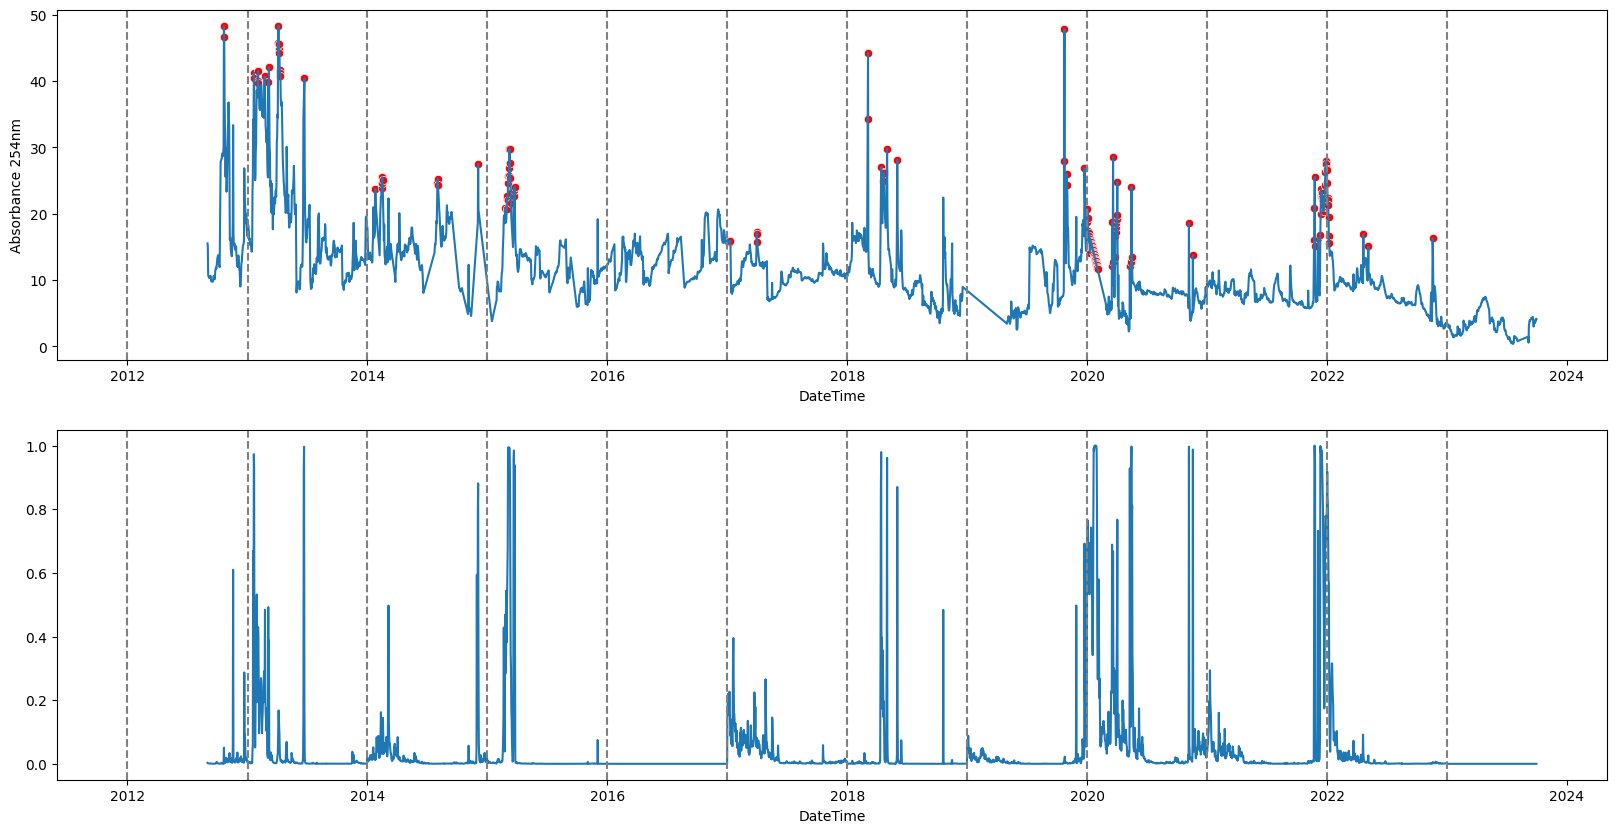

In [376]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=removed_full_df, ax=axs[0])
sns.scatterplot(x=removed_full_df['DateTime'], y=removed_full_df[removed_full_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')
        

plt.show()

# Remove Redox Potential

In [280]:
formula = 'is_outlier ~ Timestamp + C(Year) + Q("Daily Cumulated Rainfall") + Q("Air Temperature") + Conductivity + Q("Dissolved Oxygen") + Turbidity'

In [319]:
logit_model = sm.GLM.from_formula(formula=formula, data=removed_full_df, family=sm.families.Binomial())

In [282]:
results = logit_model.fit(maxiter=10000)

In [283]:
print(results.summary2())

                      Results: Generalized linear model
Model:                   GLM                  AIC:                620.8363   
Link Function:           Logit                BIC:                -27001.2877
Dependent Variable:      is_outlier           Log-Likelihood:     -294.42    
Date:                    2024-03-11 12:57     LL-Null:            -642.56    
No. Observations:        3408                 Deviance:           588.84     
Df Model:                15                   Pearson chi2:       7.17e+03   
Df Residuals:            3392                 Scale:              1.0000     
Method:                  IRLS                                                
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                     54.6171  21.7203  2.5146 0.0119 12.0461 97.1881
C(Year)[

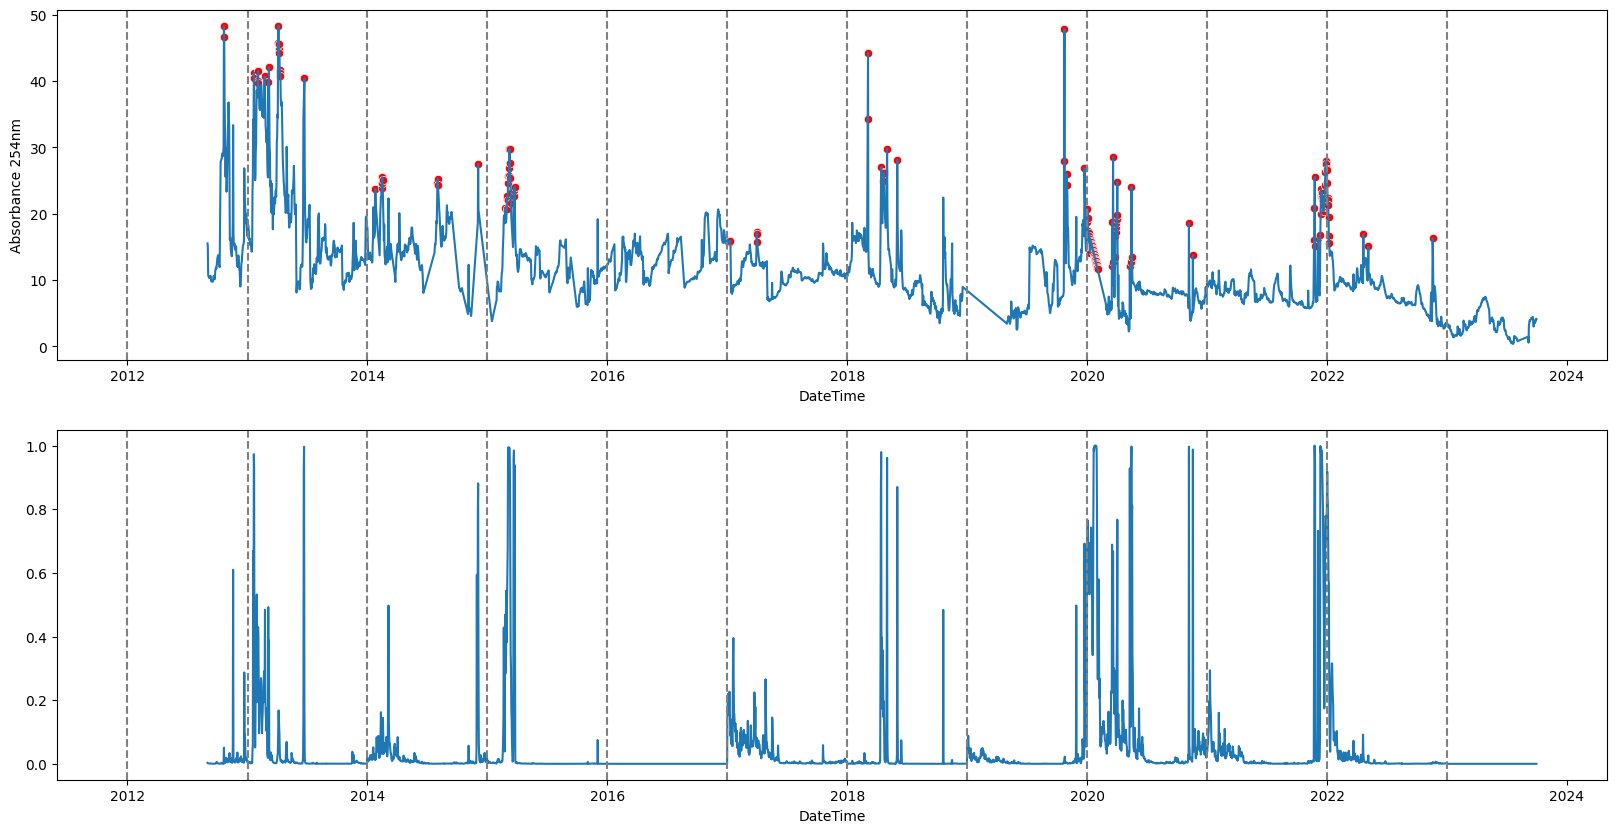

In [377]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Absorbance 254nm', data=removed_full_df, ax=axs[0])
sns.scatterplot(x=removed_full_df['DateTime'], y=removed_full_df[removed_full_df['is_outlier'] == 1]['Absorbance 254nm'], ax=axs[0], color='red')
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

# Plot other variables

In [288]:
removed_full_df.columns.to_list()

['DateTime',
 'Nitrate',
 'Absorbance 254nm',
 'pH',
 'Ammonium',
 'Dissolved Oxygen',
 'Redox Potential',
 'Turbidity',
 'Water Temperature',
 'Conductivity',
 'Daily Cumulated Rainfall',
 'Air Temperature',
 'Flow River',
 'is_outlier',
 'Timestamp',
 'Year',
 'Month']

## Water Temperature

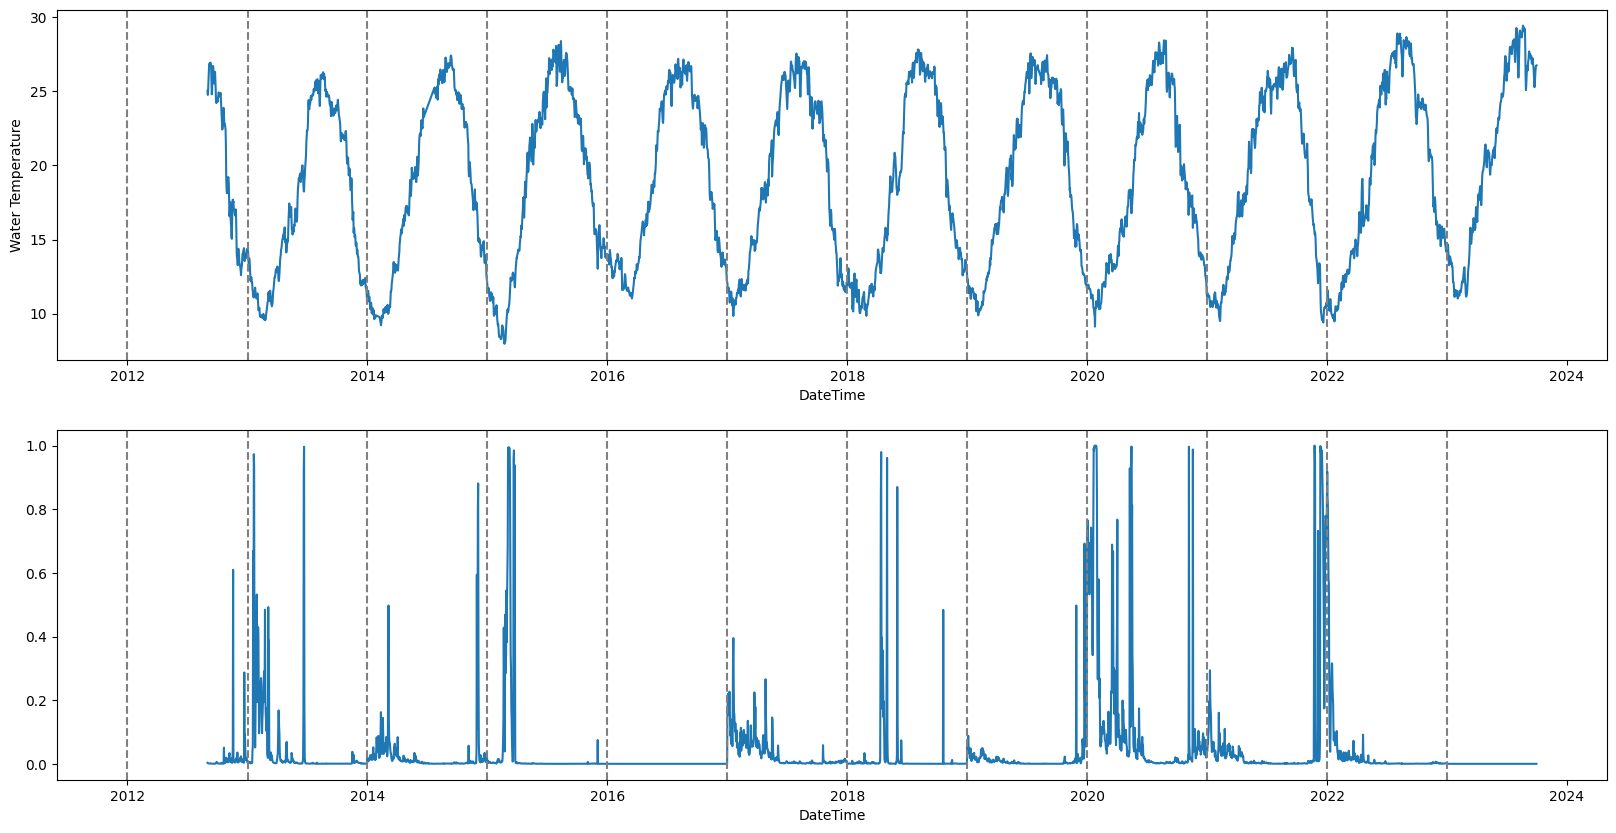

In [378]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Water Temperature', data=removed_full_df, ax=axs[0])
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

## Conductivity

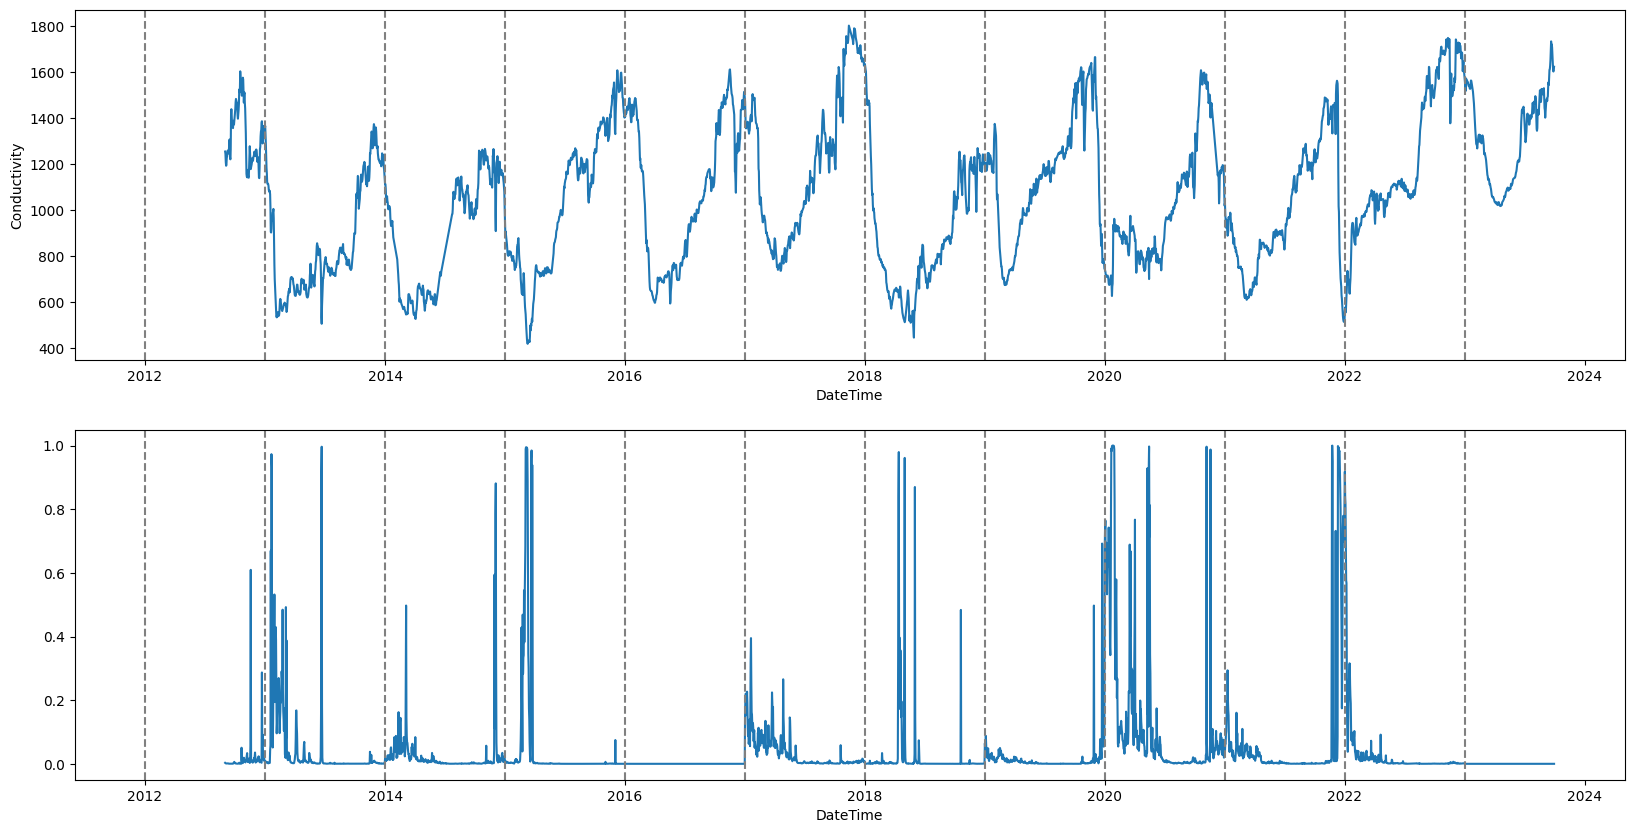

In [379]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Conductivity', data=removed_full_df, ax=axs[0])
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

## Daily Cumulated Rainfall

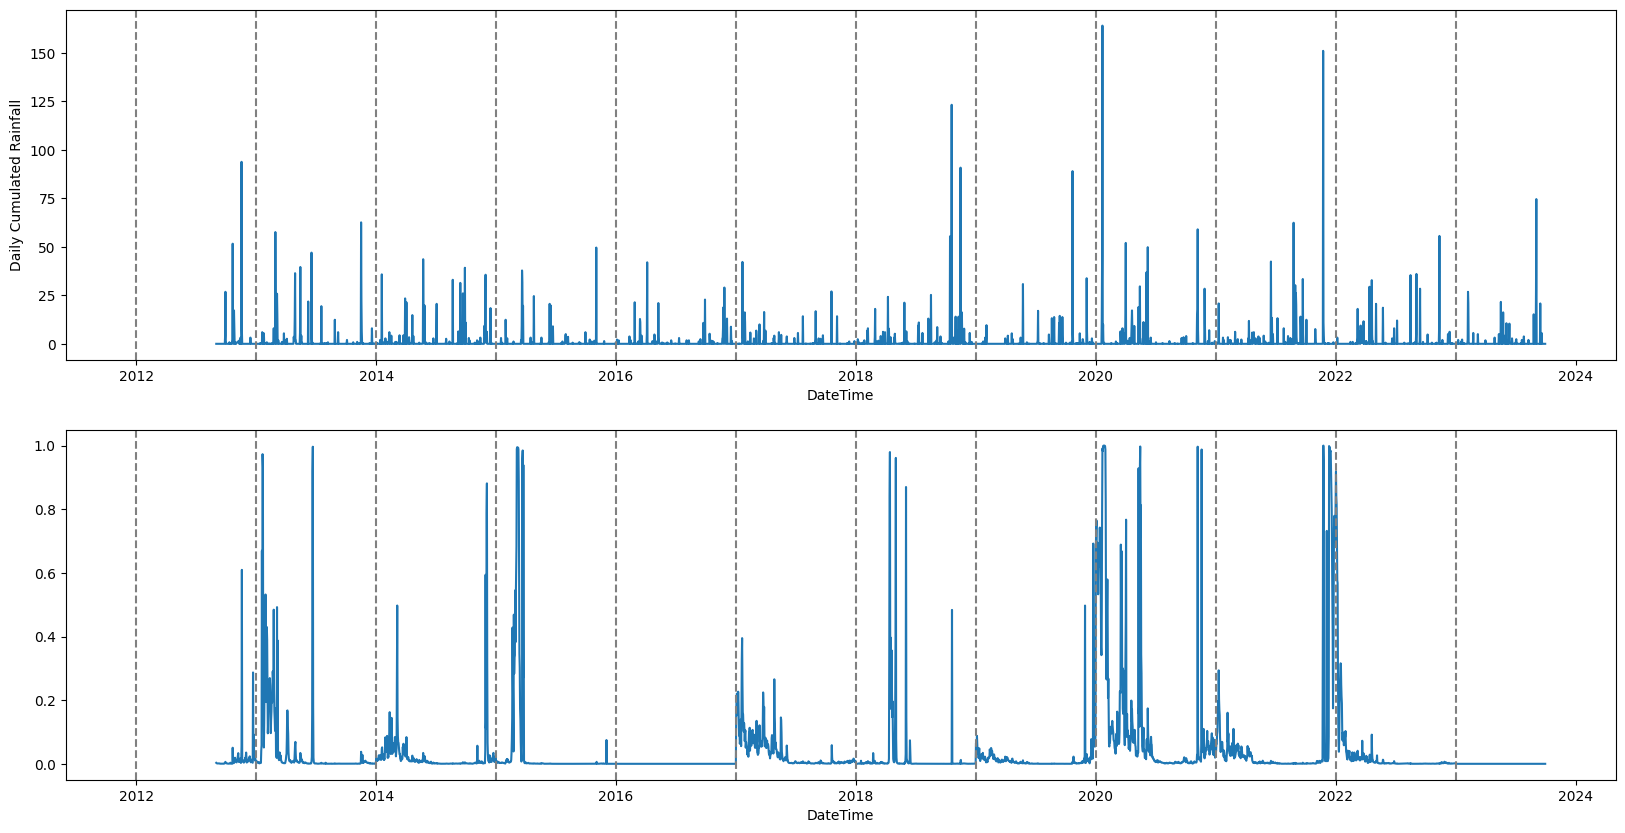

In [380]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Daily Cumulated Rainfall', data=removed_full_df, ax=axs[0])
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()

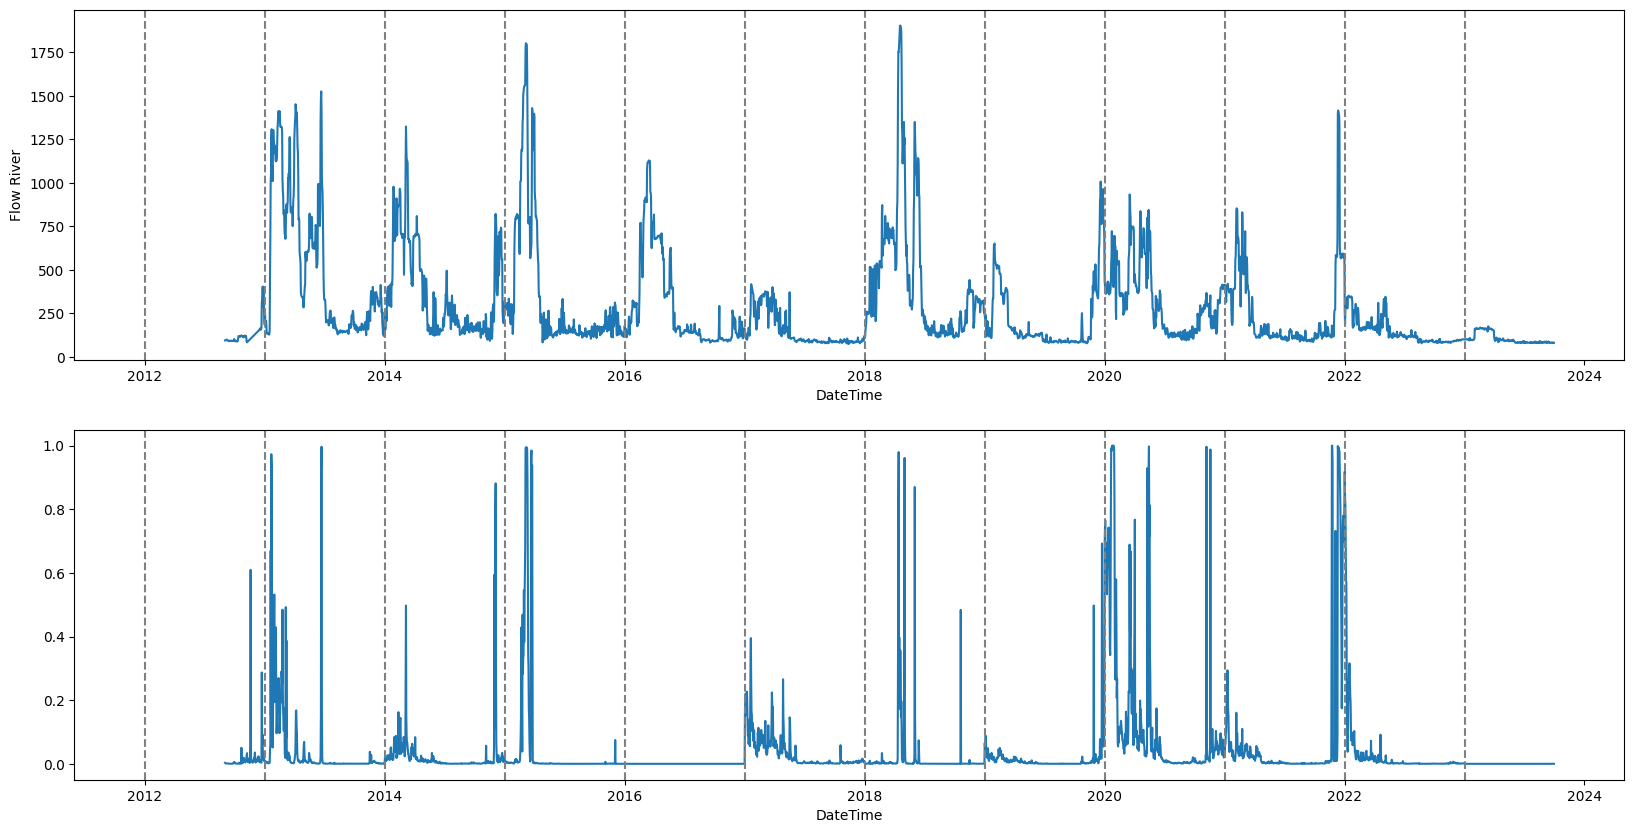

In [381]:
scaled_fitted_values = scaler.fit_transform(results.fittedvalues.values.reshape(-1, 1))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(x='DateTime', y='Flow River', data=removed_full_df, ax=axs[0])
sns.lineplot(x=removed_full_df['DateTime'], y=scaled_fitted_values.flatten(), ax=axs[1])

# plot vertical lines for the years on the entire plot
for year in removed_full_df['DateTime'].dt.year.unique():
    for ax in axs:
        ax.axvline(pd.to_datetime(str(year)), color='gray', linestyle='--')

plt.show()